In [2]:
import os
import sys
import mne
import matplotlib as plt
import sleepeegpy
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import yasa

import mne
import numpy as np
import pooch
from sleepeegpy.pipeline import (
    CleaningPipe,
    ICAPipe,
    SpectralPipe,
    SpindlesPipe,
    SlowWavesPipe,
    RapidEyeMovementsPipe,
)
from sleepeegpy.dashboard import create_dashboard

from os import makedirs

# Load EEG file (modify the filename)
raw = mne.io.read_raw_edf("2024-11-22_14-08-21_8e19cc41_27_electrodes.edf", preload=True)

# # Apply bandpass and notch filtering
raw.crop(tmin=18000)
raw.filter(l_freq=0.75, h_freq=40, picks="eeg")  # Bandpass: 0.75-40 Hz
raw.notch_filter(freqs=50, picks="eeg")  # Remove 50Hz powerline noise

# # Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(raw, duration=2.0)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / raw.info['sfreq']
    #buffer_time = 1.5  # Adjust as needed
    #onset_corrected = onset - buffer_time
    raw.annotations.append(onset, 3, "BAD")


# 🔹 Detect bad channels based on variance (using thresholding)
# bad_channels = mne.preprocessing.find_bad_channels_eeg(raw, method="variance", picks="eeg")

# raw.info["bads"] = bad_channels
# print(f"🚨 Bad channels detected: {bad_channels}")


Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/2024-11-22_14-08-21_8e19cc41_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 13518079  =      0.000 ... 52804.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Not setting metadata
17402 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17402 events and 512 original time points ...
0 bad epochs dropped


In [3]:
fig = raw.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.9


Channels marked as bad:
none


In [4]:
print(raw.info)
print(raw.annotations.description)  # The names of the annotations
print(raw.annotations.onset)        # The time (in seconds) when they occur
print(raw.annotations.duration) 

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FP2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, TP7, ...
 chs: 30 EEG
 custom_ref_applied: False
 highpass: 0.8 Hz
 lowpass: 40.0 Hz
 meas_date: 2024-11-22 14:08:21 UTC
 nchan: 30
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>
['RELAX ' 'BAD' 'BAD' 'Missing 5 samples / 0,02 seconds' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'Missing 1 samples / 0,00 seconds'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'Missing 1 samples / 0,00 seconds' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'B

In [5]:
output_dir = "output_folder"  # Output path and name can be changed here
input_dir = "input_files"  # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

subject_code = "Marcus" # The subject code that will appear in the dashboard
# eeg_file = "s01_cleaned_eeg_with_annotations.fif"
bad_channels = "bad_channels.txt"
annotations = "annotations.txt"
hypnogram_filename = "staging.txt"
hypno_freq = 1  # If required, change the Hypnogram's sampling frequency (Visbrain's hypnograms default to 1)
hypno_selection = "automatically"
annotations_selection = "from-file"
bad_channels_selection = "automatically"

if hypno_selection == "automatically":
    hypnogram_path = "predict"
    #### If you selected automatic hypnogram, select prediction arguments. ####
    hypno_predict_arguments = {
        "eeg_name": "C4", #(C4)
        "eog_name": None, #(EOG1)
        "emg_name": None,
        "ref_name" : "Cz",
    }
else:
    hypno_predict_arguments = None

n_components = 25 # initial was 30
picked_channel = "Pz"  # (Pz)
loc_chname = "R1"  # (EOG1)
roc_chname = "R2"  # (EOG2)

#path_to_eeg = os.path.join(input_dir, eeg_file)
if hypno_selection == "from-file":
    hypnogram_path = os.path.join(input_dir, hypnogram_filename)
bad_channels = (
    None if bad_channels_selection == "automatically" else os.path.join(input_dir, bad_channels))
annotations = ( None if annotations_selection == "automatically" else os.path.join(input_dir, annotations))

## 1. Cleaning

In [6]:
path_to_eeg = os.path.join(input_dir, "2024-11-22_14-08-21_8e19cc41_27_electrodes.edf")
pipe = CleaningPipe(path_to_eeg=path_to_eeg, output_dir=output_dir)
start_time = 18000
pipe.mne_raw.crop(tmin=start_time)

# Apply bandpass and notch filtering

pipe.resample(sfreq=256, n_jobs=-1, verbose=False)
pipe.filter(l_freq=0.75, h_freq=40, n_jobs=-1,) # Bandpass
pipe.notch(freqs=50, n_jobs=-1,) #Notch

Extracting EDF parameters from /Users/patriciaalmeida/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/DTU/Spring 2025/Special course/sleepeeg/input_files/2024-11-22_14-08-21_8e19cc41_27_electrodes.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8910079  =      0.000 ... 34804.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.75 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.75
- Lower transition bandwidth: 0.75 Hz (-6 dB cutoff frequency: 0.38 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1127 samples (4.402 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.3s
/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


In [ ]:
# Detect bad segments automatically
epochs = mne.make_fixed_length_epochs(pipe.mne_raw, duration=2)
stds = np.std(epochs.get_data(), axis=(1, 2))
threshold = np.mean(stds) + 2 * np.std(stds)
bad_epochs = np.where(stds > threshold)[0]

# # Annotate detected bad segments
for epoch_idx in bad_epochs:
    onset = epochs.events[epoch_idx, 0] / pipe.mne_raw.info['sfreq']
    pipe.mne_raw.annotations.append(onset, 2, "BAD")

Not setting metadata
17402 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17402 events and 512 original time points ...
0 bad epochs dropped


In [8]:
fig = pipe.mne_raw.plot()
print(pipe.mne_raw.annotations)

Using pyopengl with version 3.1.9
<Annotations | 613 segments: BAD (607), Missing 1 samples / 0,00 seconds ...>


Channels marked as bad:
none


In [9]:
# Load a standard 10-20 montage
montage = mne.channels.make_standard_montage("standard_1020")

# Get only the channels that exist in the montage
valid_channels = [ch for ch in pipe.mne_raw.ch_names if ch in montage.ch_names]
pipe.mne_raw.pick_channels(valid_channels)

# Apply montage
pipe.mne_raw.set_montage(montage)

# Now run bad channel detection
#bad_channels = pipe.auto_detect_bad_channels()

pipe.mne_raw.info

pipe.set_eeg_reference(ref_channels="average", projection=True)

if bad_channels_selection == "manually":
    pipe.plot(save_bad_channels=True)
elif bad_channels_selection == "automatically":
    bad_channels = pipe.auto_detect_bad_channels()

pipe.read_bad_channels(path=None if bad_channels_selection == "Manually" else bad_channels)

pipe.interpolate_bads(reset_bads=True)

if annotations_selection == "manually":
    pipe.plot(butterfly=True, save_annotations=True, overwrite=True)
    pipe.read_annotations()
elif annotations_selection == "from-file":
    pipe.read_annotations(path=annotations)
elif annotations_selection == "automatically":
    pipe.auto_set_annotations()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/41 [00:00<?,       ?it/s]


RANSAC done!
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.6s


Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/6919 [00:00<?,       ?it/s]


RANSAC done!
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.3 mm
Computing interpolation matrix from 12 sensor positions
Interpolating 13 sensors


Interpolated channels: ['Fz', 'F8', 'Cz', 'F3', 'T9', 'T7', 'O1', 'P3', 'T10', 'P9', 'F4', 'F7', 'P7']


In [9]:
recording_start = pipe.mne_raw.info["meas_date"]  # Get actual recording datetime
if isinstance(recording_start, tuple):  # MNE sometimes returns a tuple
    recording_start = recording_start[0]

# Convert to datetime format (if needed)
if isinstance(recording_start, float):
    recording_start = datetime.datetime.utcfromtimestamp(recording_start)

print(f"Recording started at: {recording_start}")

crop_offset = 18000  # The EEG was cropped at 20,000 sec
new_start_time = recording_start + datetime.timedelta(seconds=crop_offset)

print(f"Adjusted Recording Start (After Cropping): {new_start_time}")

Recording started at: 2024-11-22 14:08:21+00:00
Adjusted Recording Start (After Cropping): 2024-11-22 19:08:21+00:00


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


average reference has been applied


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Hypnogram is SHORTER than data by 5.0 seconds. Padding hypnogram with last value to match data.size.


Setting 310784 of 8910080 (3.49%) samples to NaN, retaining 8599296 (96.51%) samples.
Setting 310784 of 8910080 (3.49%) samples to NaN, retaining 8599296 (96.51%) samples.


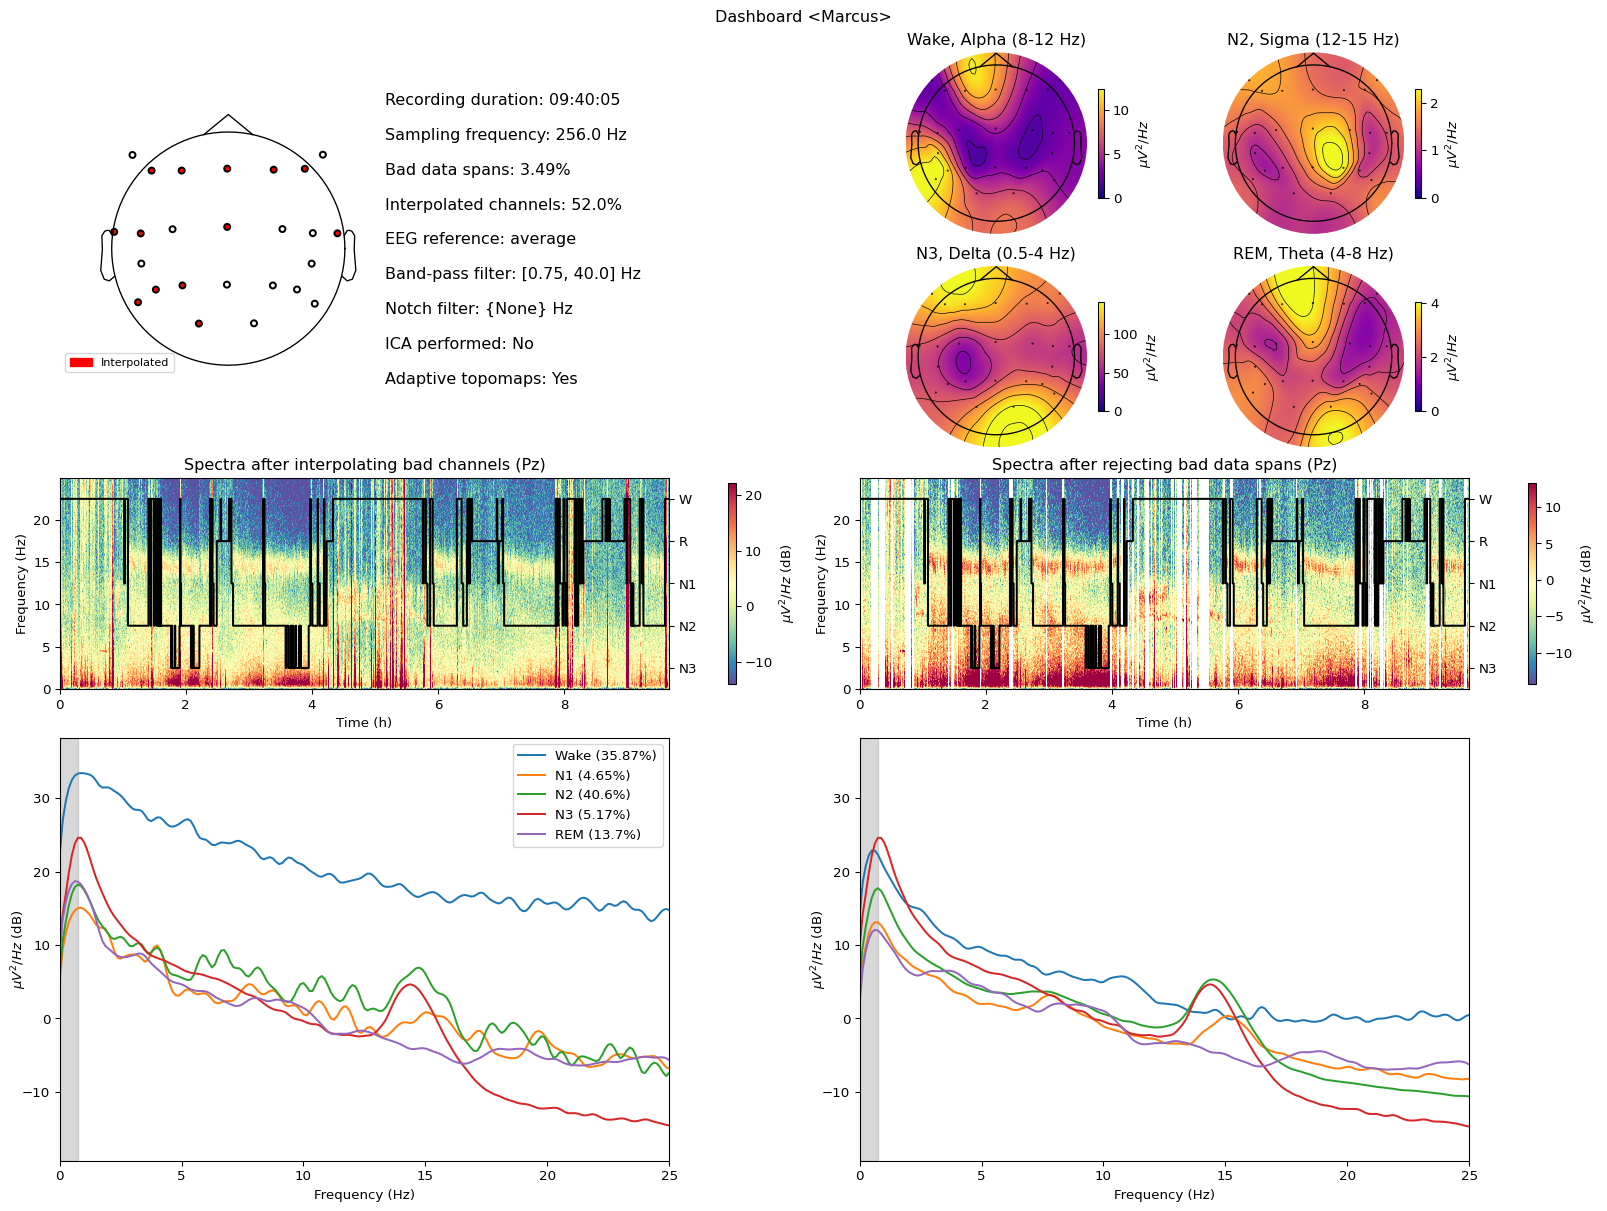

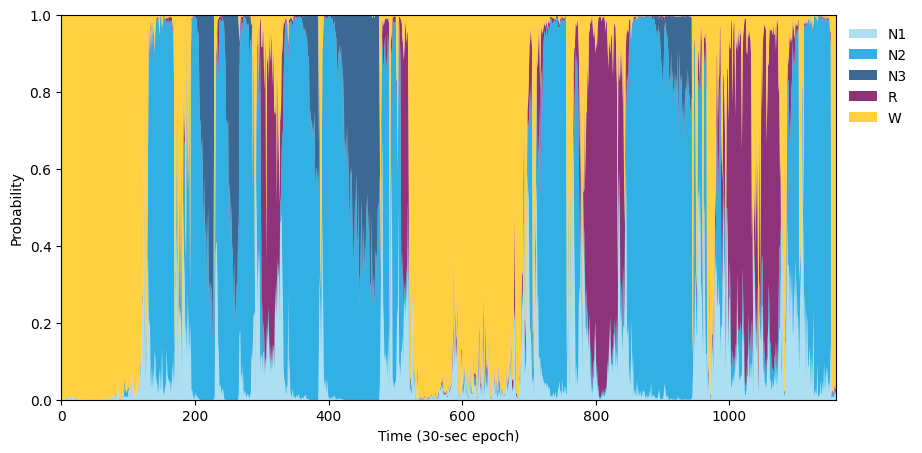

In [10]:

# os.environ["NUMBA_DISABLE_JIT"] = "1"
fig = create_dashboard(
    subject_code=subject_code,
    prec_pipe=pipe,
    hypno_psd_pick=picked_channel,
    hypnogram=hypnogram_path,
    predict_hypno_args=hypno_predict_arguments,
    hypno_freq=hypno_freq,
    reference="average",
)


## 2. Spectral

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
Hypnogram is SHORTER than data by 5.0 seconds. Padding hypnogram with last value to match data.size.


Setting 310784 of 8910080 (3.49%) samples to NaN, retaining 8599296 (96.51%) samples.


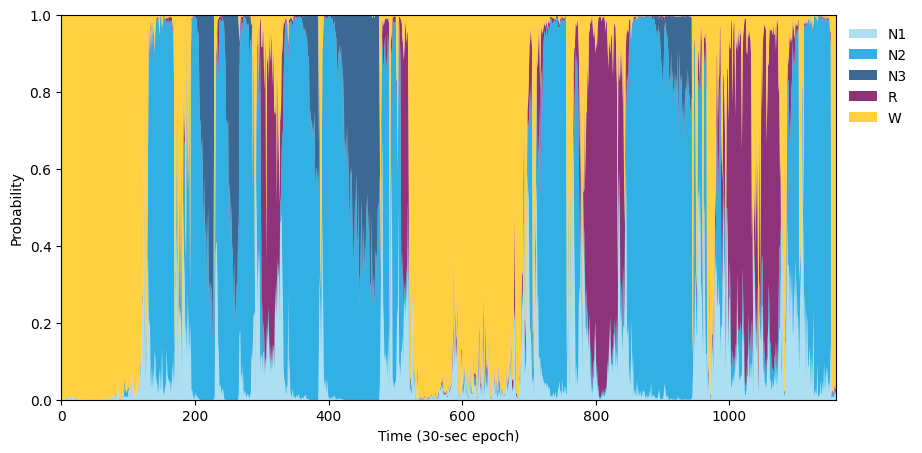

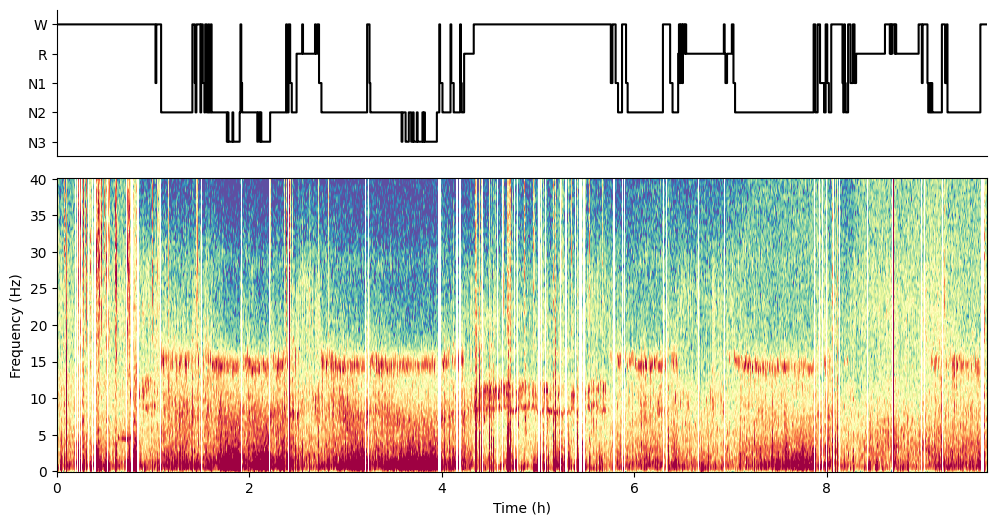

In [11]:
if hypnogram_path and hypnogram_path!="predict":
    spectral_pipe = SpectralPipe(prec_pipe=pipe,path_to_hypno=hypnogram_path,hypno_freq=hypno_freq)
else:
    spectral_pipe = SpectralPipe(prec_pipe=pipe)

if hypnogram_path is None or hypnogram_path=="predict":
    spectral_pipe.predict_hypno(
    eeg_name = hypno_predict_arguments["eeg_name"],
    eog_name = hypno_predict_arguments["eog_name"],
    emg_name =  hypno_predict_arguments["emg_name"],
    ref_name = hypno_predict_arguments["ref_name"],
    save=True)

spectral_pipe.plot_hypnospectrogram(picks=[picked_channel],save=True)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Setting 310784 of 8910080 (3.49%) samples to NaN, retaining 8599296 (96.51%) samples.
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size

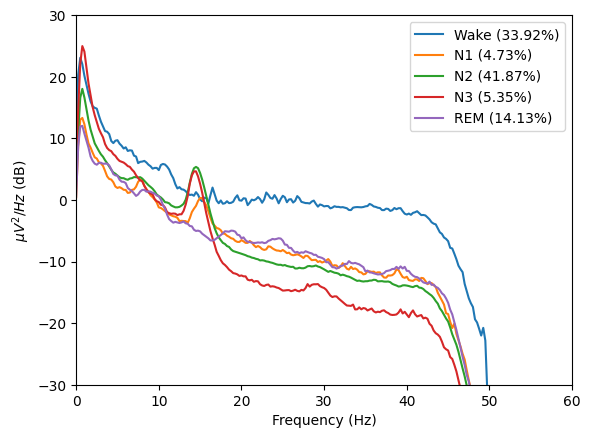

In [12]:
spectral_pipe.compute_psd(
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    reference="average",
    # Additional arguments passed to the Welch method:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
    verbose=True,
    save=False,
)
spectral_pipe.plot_psds(picks=[picked_channel], psd_range=(-30, 30),save=True)

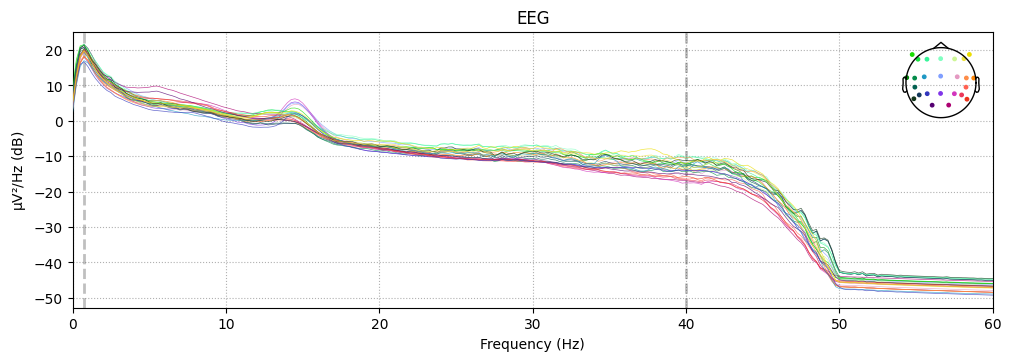

In [13]:
_ = spectral_pipe.psds["N2"].plot(picks="data", exclude ="bads", show=False)

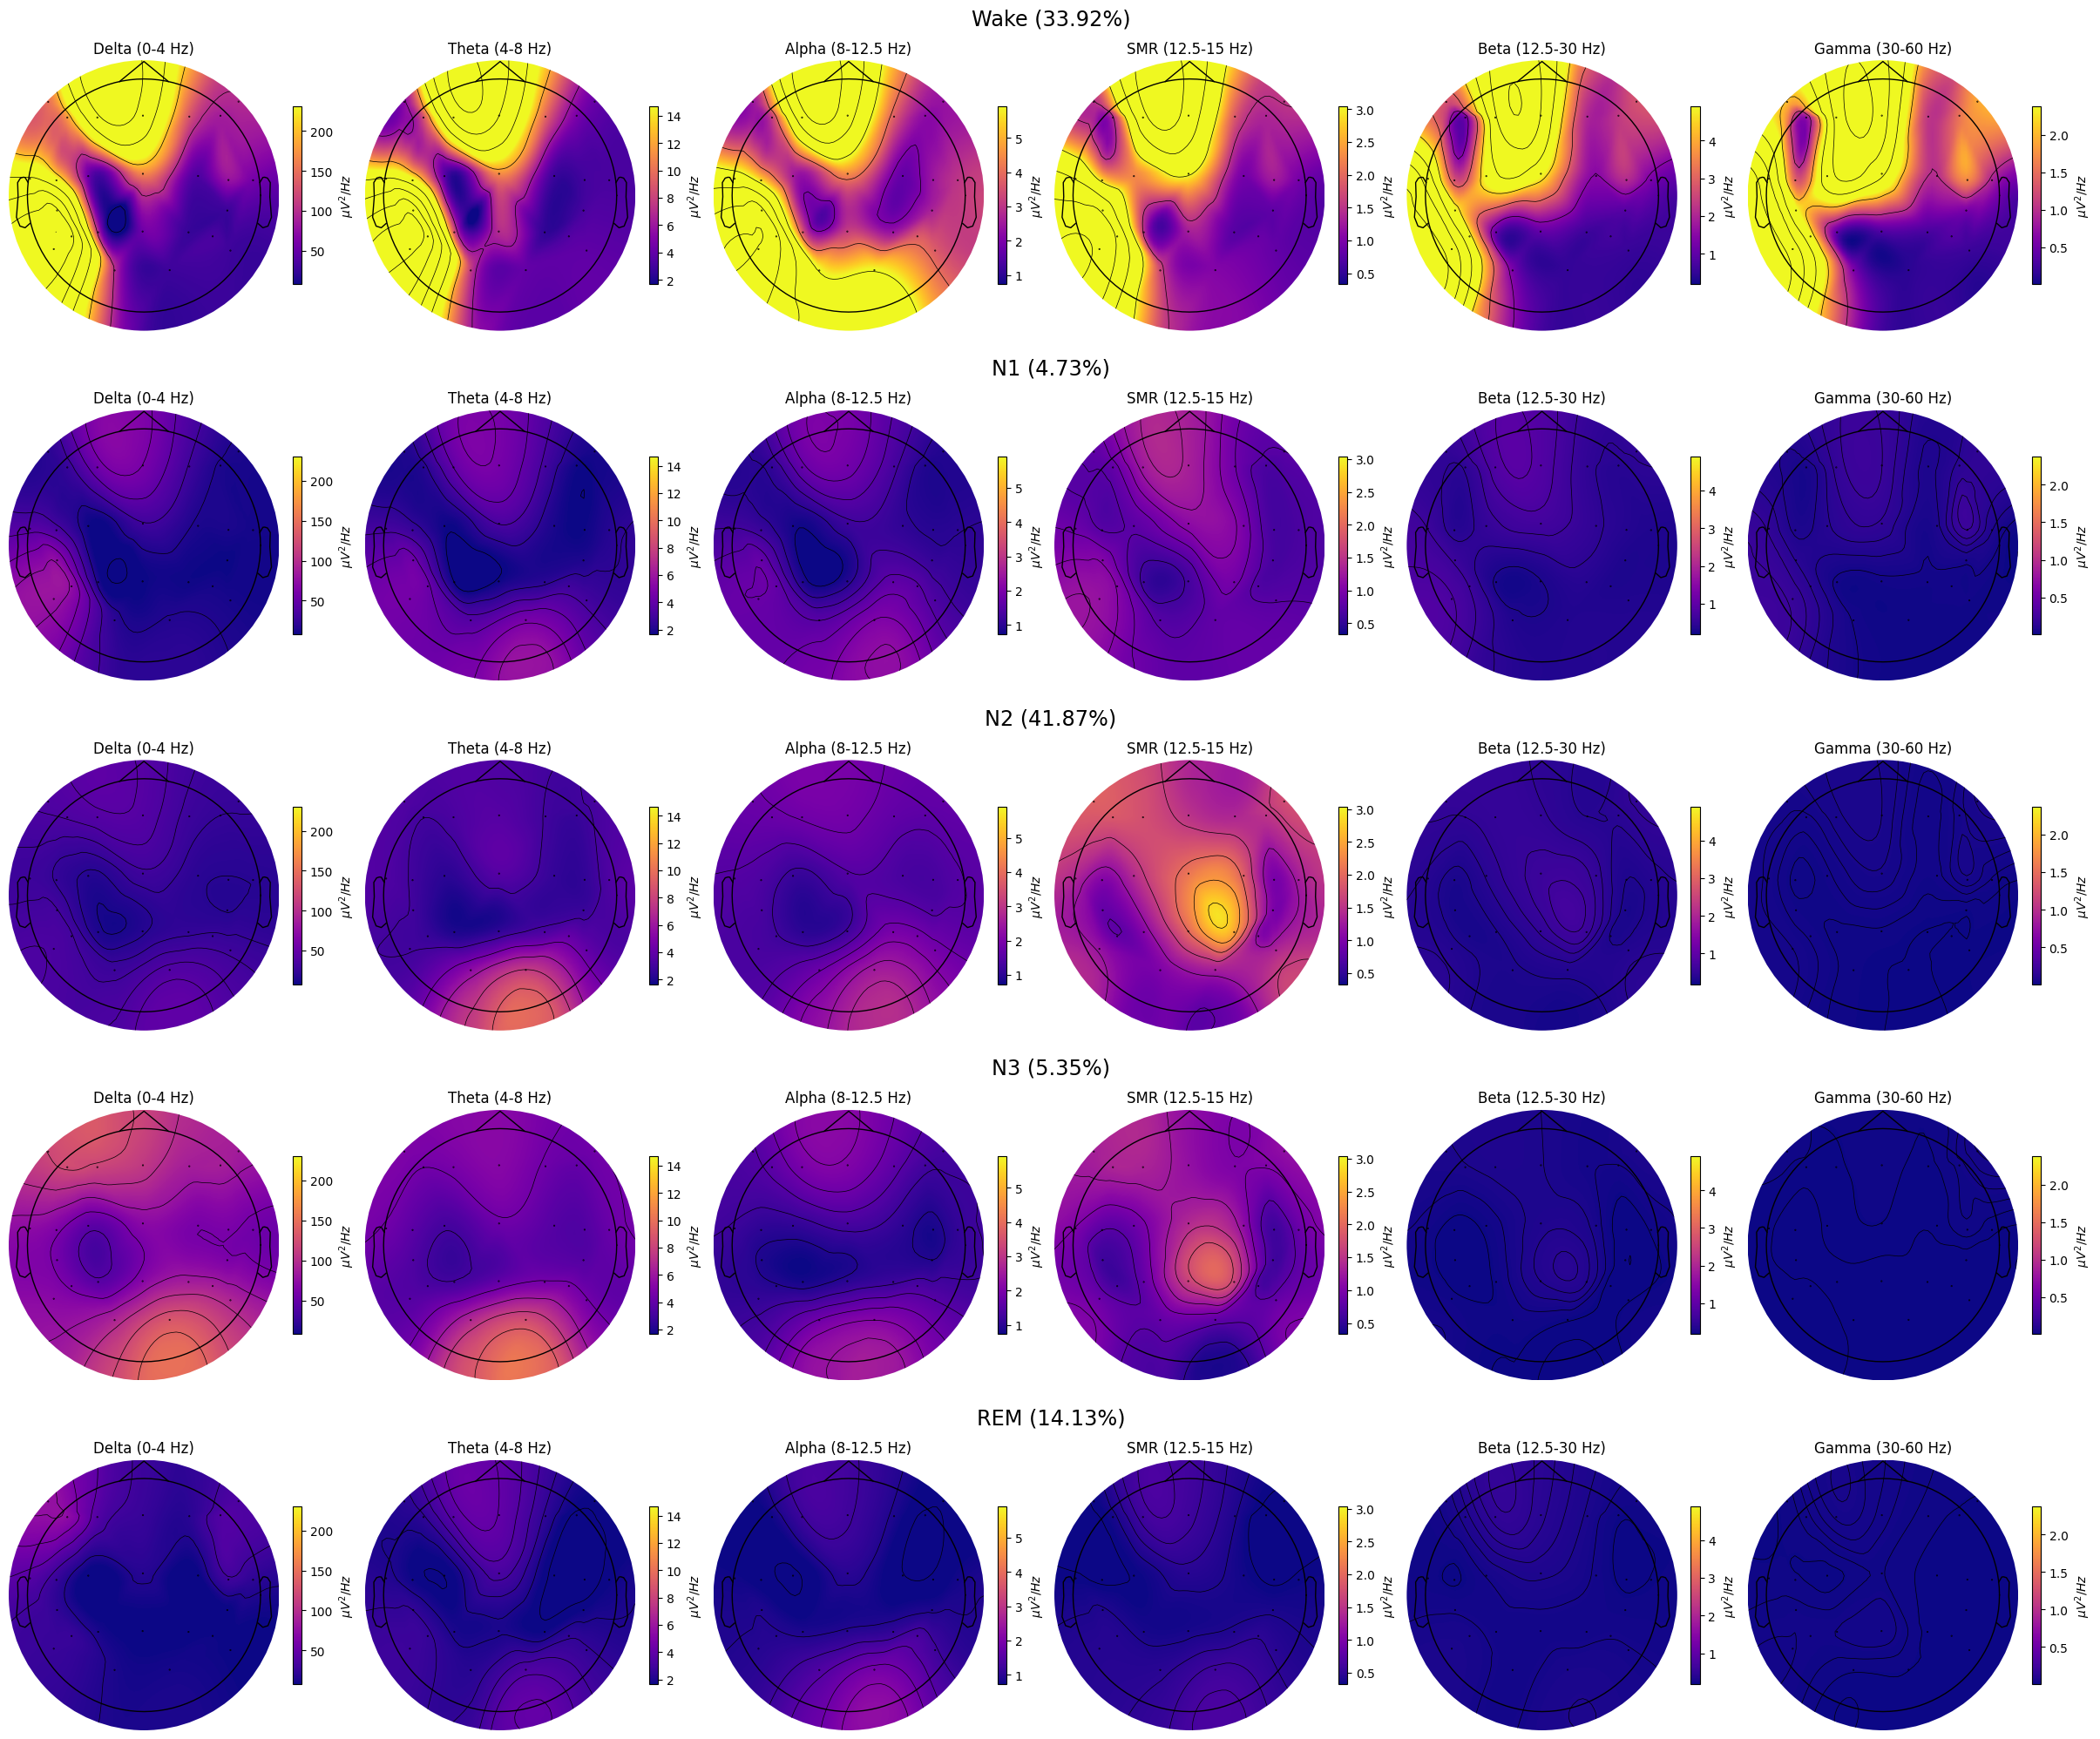

In [15]:
spectral_pipe.plot_topomap_collage(
    #  Bands to plot topomaps for.
    bands={
        "Delta": (0, 4),
        "Theta": (4, 8),
        "Alpha": (8, 12.5),
        "SMR": (12.5, 15),
        "Beta": (12.5, 30),
        "Gamma": (30, 60),
    },
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    dB=False,  # Whether to transform PSD to dB/Hz.
    low_percentile=5,  # Set min color value by percentile of the band data.
    high_percentile=95,  # Set max color value by percentile of the band data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)


Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
Running FOOOFGroup across 25 power spectra.
                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 25                             
                                                                                                  
                        The model was run on the frequency range 0 - 60 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                           

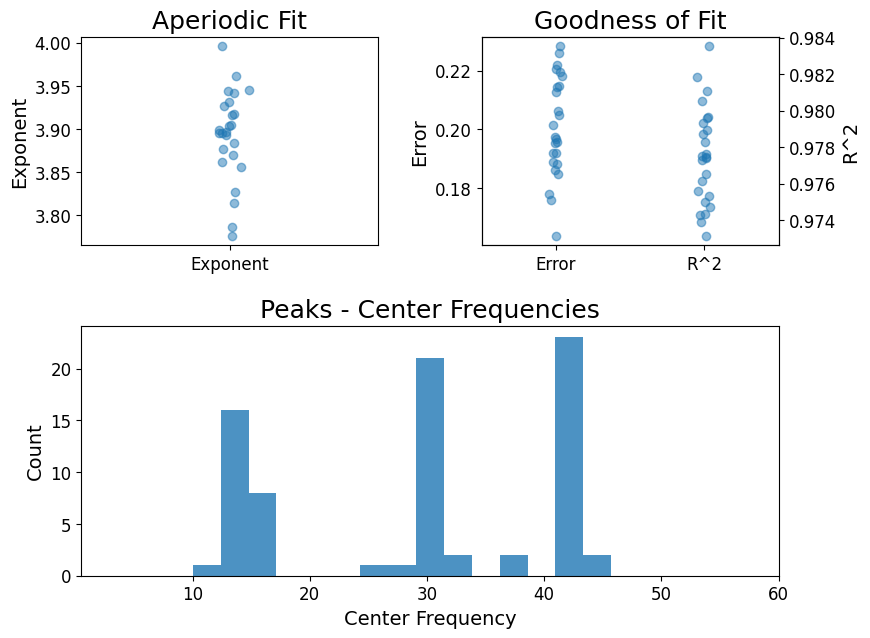

In [16]:
# Paramtrize spectrum
spectral_pipe.parametrize(
    picks=["eeg"],
    freq_range = [0.5, 60],
    average_ch=False,
)
spectral_pipe.fooofs["N2"].report()

In [18]:
spectral_pipe.sleep_stats(save=False) # in minutes

{'TIB': 580.0833333333334,
 'SPT': 514.5,
 'WASO': 142.5,
 'TST': 372.0,
 'N1': 27.0,
 'N2': 235.5,
 'N3': 30.0,
 'REM': 79.5,
 'NREM': 292.5,
 'SOL': 61.5,
 'Lat_N1': 61.5,
 'Lat_N2': 65.0,
 'Lat_N3': 106.0,
 'Lat_REM': 149.5,
 '%N1': 7.258064516129032,
 '%N2': 63.306451612903224,
 '%N3': 8.064516129032258,
 '%REM': 21.370967741935484,
 '%NREM': 78.62903225806451,
 'SE': 64.12871713834218,
 'SME': 72.30320699708454}

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 0 - 60 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -9.3738, 3.8696                                          
                                                                                                  
                                       3 peaks were found:                                        
          

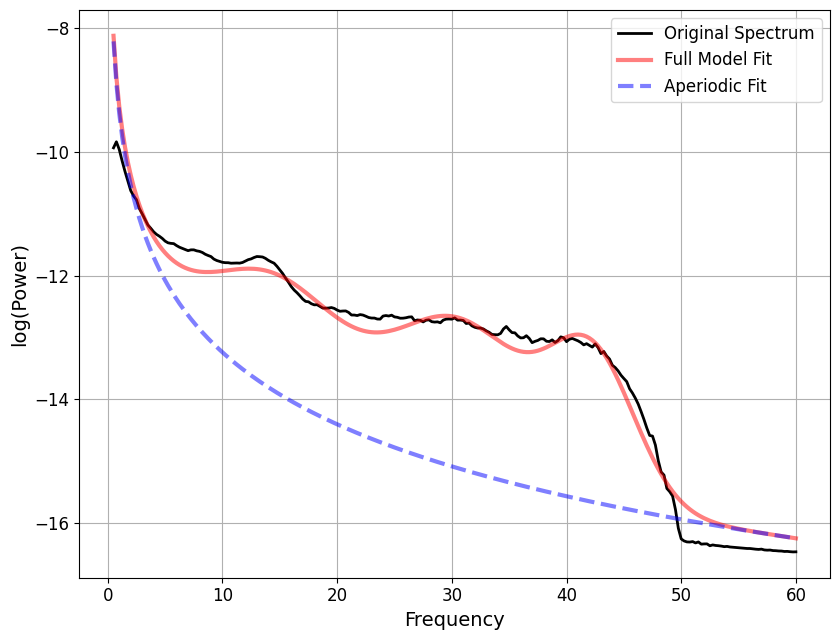

In [19]:
spectral_pipe.fooofs["N2"].get_fooof(ind=0).report()

In [20]:
from fooof.analysis import get_band_peak_fg

smr_peaks = get_band_peak_fg(spectral_pipe.fooofs["N2"], band=[12.5, 15]) # sigma band - includes sleep spindles and sensory-motor rhythm (smr)
smr_peaks #returns peaks
# centered frequency, power of the peak, bandwith

array([[14.8392496 ,  1.91635112, 11.67013274],
       [14.76815593,  2.02692362, 11.99995499],
       [        nan,         nan,         nan],
       [        nan,         nan,         nan],
       [14.89402787,  2.15522279, 11.99999946],
       [14.14603977,  2.26010369, 11.41790945],
       [13.4939015 ,  2.05231148, 12.        ],
       [13.26308771,  2.03631358, 12.        ],
       [14.40627282,  2.01560781, 11.30816061],
       [14.83414895,  2.09157198, 12.        ],
       [14.11262594,  1.90818428, 11.79837972],
       [14.69198068,  2.12741403, 12.        ],
       [14.39500704,  1.73105906, 11.99991407],
       [        nan,         nan,         nan],
       [14.66449109,  1.73022034, 11.99999997],
       [13.89916972,  2.07479611, 12.        ],
       [14.70317627,  2.02325686, 11.75281285],
       [13.32437027,  2.04972477, 10.01137763],
       [14.55646498,  1.92464753, 11.99999947],
       [14.40931177,  2.18414656, 12.        ],
       [14.96026654,  1.74277882, 11.958

## 3. Events

### 3.1. Sleep spindles

Hypnogram is SHORTER than data by 5.0 seconds. Padding hypnogram with last value to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


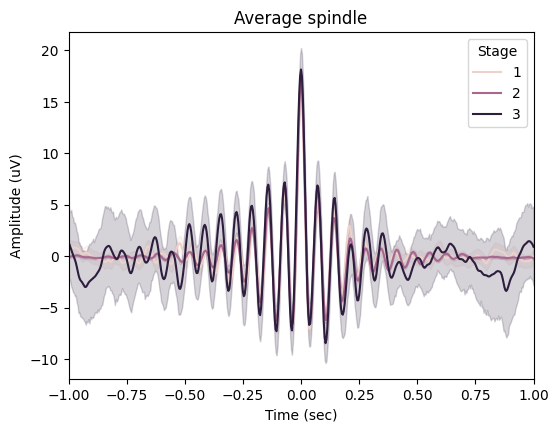

In [21]:
spindles_pipe = SpindlesPipe(prec_pipe=spectral_pipe)

spindles_pipe.detect()
spindles_pipe.plot_average(
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
    save=True
)

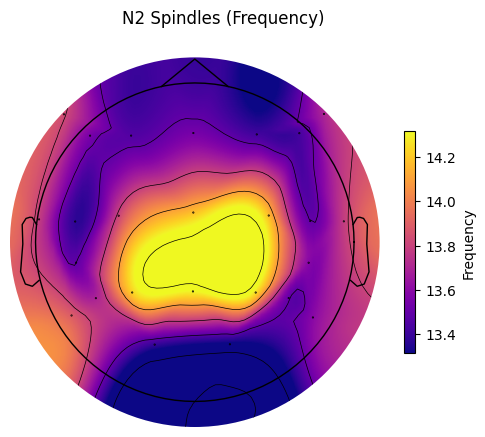

In [22]:
spindles_pipe.plot_topomap(
    prop="Frequency",  #  Any of the event properties returned by pipe.results.summary().
    stage="N2",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

In [23]:
spindles_pipe.results.summary(grp_chan=False, grp_stage=True)

Count    Density  Duration  Amplitude       RMS  AbsPower  RelPower  \
Stage                                                                        
1        439  16.259259  0.773446  33.736112  7.285160  1.645352  0.361016   
2      15272  64.849257  0.842864  35.786068  7.688810  1.703887  0.377968   
3         77   2.566667  0.646763  38.197155  8.775041  1.865440  0.321876   

       Frequency  Oscillations  Symmetry  
Stage                                     
1      14.037957      9.587699  0.502520  
2      13.824074     10.525340  0.497398  
3      13.833180      8.337662  0.526431

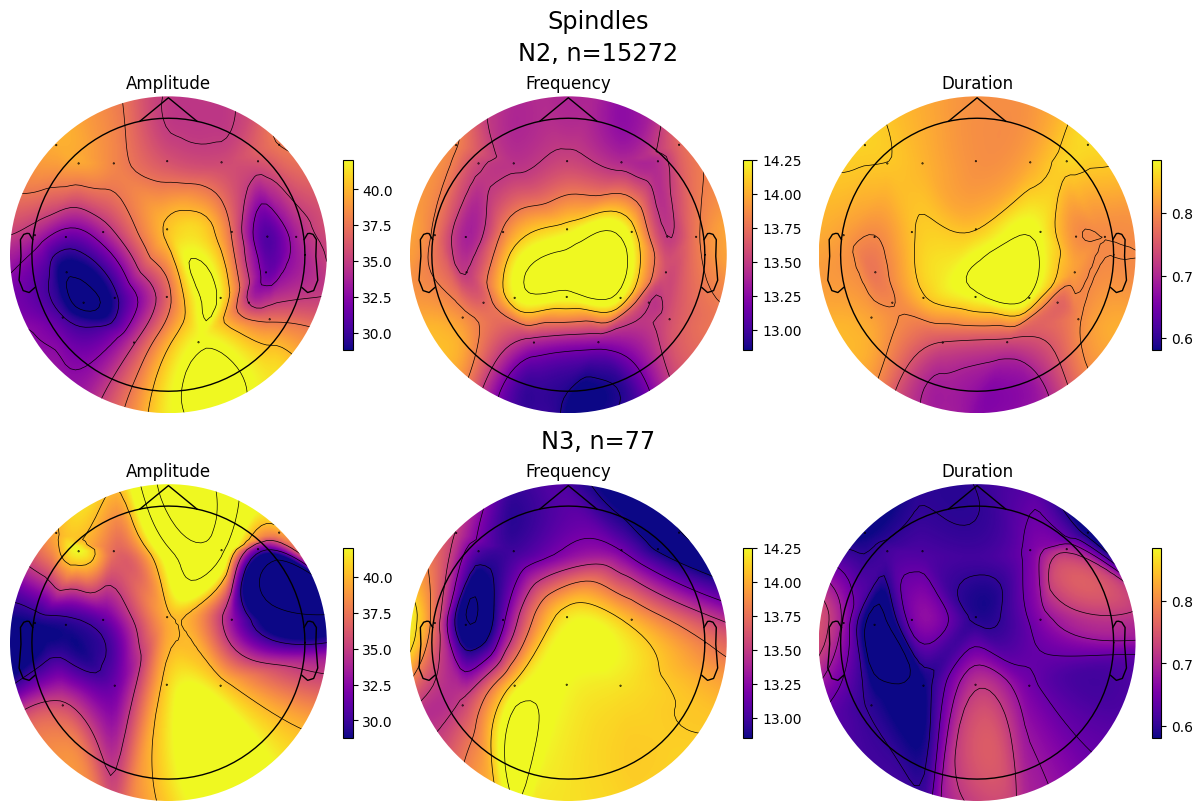

In [24]:
spindles_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Amplitude", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)


In [25]:
spindles_pipe.compute_tfr(
    freqs=(10, 20),  # Interval of frequencies of interest.
    n_freqs=100,  # TFR frequency resolution.
    time_before=1,  # Time in sec before the peak to use in TFR computation. Should be positive.
    time_after=1,  # Time in sec after the peak to use in TFR computation.
    method="morlet",  # TFR method: 'morlet' or 'multitaper'.
    save=False,  # Whether to save AverageTFR object per sleep stage as hdf5 file.
    overwrite=False,  # Whether to overwrite existing files.
)

spindles_pipe.tfrs

100%|██████████| 15/15 [00:00<00:00, 61.48it/s]


{'N2': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 610, channels : 25, ~9.8 MB>,
 'N1': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 17, channels : 25, ~9.8 MB>,
 'N3': <AverageTFR | time : [-1.000000, 1.000000], freq : [10.000000, 20.000000], nave : 5, channels : 15, ~5.9 MB>}

In [26]:
spindles_pipe.tfrs["N2"].data

array([[[146.86804966, 151.56241119, 156.16785229, ..., 196.35632302,
         190.48821533, 184.52529121],
        [145.45578698, 150.16016466, 154.7757717 , ..., 195.14526394,
         189.24239252, 183.24444759],
        [144.11987626, 148.8372671 , 153.46615754, ..., 194.00090754,
         188.05972695, 182.02339566],
        ...,
        [ 49.68994684,  51.80498787,  53.66781085, ...,  61.62908706,
          59.54043804,  57.15761047],
        [ 49.0439108 ,  51.11801574,  52.93793584, ...,  60.94777863,
          58.89393501,  56.54405028],
        [ 48.41424642,  50.44885863,  52.227443  , ...,  60.28210376,
          58.26207799,  55.94419789]],

       [[192.6113151 , 199.06063845, 205.42485096, ..., 247.71924401,
         239.10997165, 230.47038213],
        [190.24517348, 196.64033858, 202.94662202, ..., 245.12295919,
         236.53137229, 227.90818441],
        [187.95396478, 194.29554507, 200.54431743, ..., 242.53816189,
         233.96561627, 225.36023584],
        ...,


In [27]:
spindles_pipe.tfrs["N2"].to_data_frame()

time  freq          C3          C4          Cz         F10  \
0     -1.000000  10.0  146.868050  192.611315  220.828511  212.317924   
1     -0.996094  10.0  151.562411  199.060638  227.813055  219.399449   
2     -0.992188  10.0  156.167852  205.424851  234.657897  226.391944   
3     -0.988281  10.0  160.672617  211.689333  241.345485  233.279878   
4     -0.984375  10.0  165.065662  217.840228  247.859385  240.048505   
...         ...   ...         ...         ...         ...         ...   
51295  0.984375  20.0   63.360693   61.136377   74.074770   81.322900   
51296  0.988281  20.0   61.985215   60.191296   73.305770   80.844993   
51297  0.992188  20.0   60.282104   58.903396   72.107472   79.873646   
51298  0.996094  20.0   58.262078   57.274737   70.473221   78.394861   
51299  1.000000  20.0   55.944198   55.317091   68.409015   76.409351   

               F3          F4          F7          F8  ...          P7  \
0      285.360586  219.348900  224.627774  228.348363  ...  339.534194   
1      294.574701  226.501232  232.256558  236.034304  ...  350.918920   
2      303.592436  233.548065  239.795261  243.620003  ...  362.102980   
3      312.386163  240.474330  247.226349  251.088005  ...  373.053849   
4      320.929497  247.266032  254.533033  258.421764  ...  383.740345   
...           ...         ...         ...         ...  ...         ...   
51295   72.114429   75.494736   67.155986   77.686200  ...   72.024224   
51296   71.042704   75.179926   66.267371   77.304688  ...   71.200692   
51297   69.596693   74.388796   64.993125   76.435873  ...   69.964195   
51298   67.770586   73.108006   63.332717   75.066184  ...   68.310454   
51299   65.569955   71.338561   61.296679   73.196992  ...   66.247051   

               P8          P9          Pz         T10          T7          T8  \
0      158.117547  301.793836  178.203420  187.739480  174.421336  187.438594   
1      163.841216  312.115235  184.317351  194.103012  180.697622  193.706909   
2      169.524160  322.355443  190.365228  200.378242  186.931071  199.874697   
3      175.153523  332.496438  196.333524  206.549799  193.108694  205.926327   
4      180.716891  342.521325  202.209329  212.603120  199.218088  211.847088   
...           ...         ...         ...         ...         ...         ...   
51295   64.326445   77.081005   56.194653   49.467510   56.832713   58.966822   
51296   63.205173   76.665177   55.749482   48.819125   55.508277   58.347061   
51297   61.704928   75.749290   54.955188   47.903309   53.892477   57.398198   
51298   59.835912   74.323196   53.807122   46.715603   51.995949   56.112431   
51299   57.618389   72.392162   52.310813   45.259601   49.837055   54.491907   

               T9         TP7         TP8  
0      198.503860  146.811419  209.975482  
1      205.235537  152.133186  217.850460  
2      211.896753  157.422210  225.713332  
3      218.474261  162.667702  233.550336  
4      224.955622  167.859384  241.348291  
...           ...         ...         ...  
51295   61.349841   46.782234   54.963339  
51296   60.290317   46.052215   54.219675  
51297   58.887689   45.052518   53.153502  
51298   57.148460   43.785787   51.765725  
51299   55.088230   42.262354   50.066514  

[51300 rows x 27 columns]

No baseline correction applied


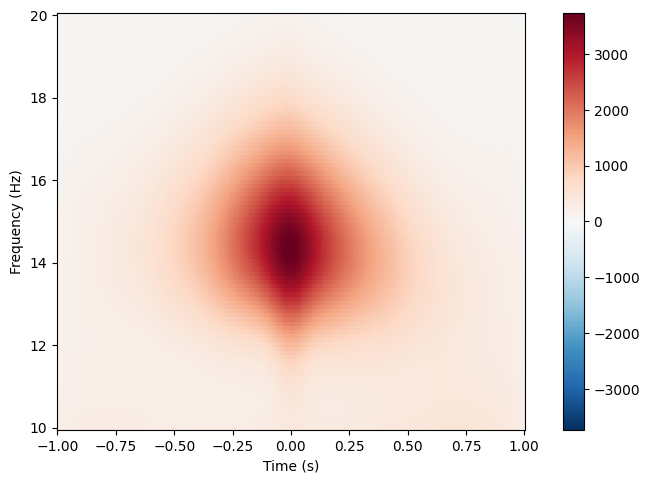

No baseline correction applied


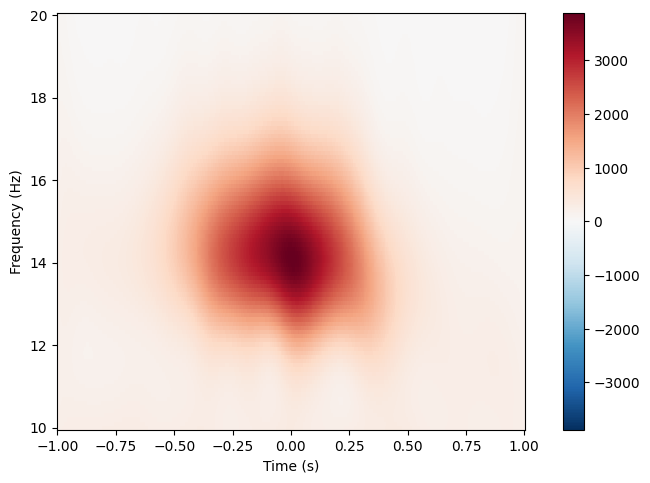

[<Figure size 640x480 with 2 Axes>]

In [28]:
spindles_pipe.tfrs["N2"].plot(["Pz"]),
spindles_pipe.tfrs["N3"].plot(["Pz"])

#### Picked channels results

In [29]:
spindles_pipe.detect(picks=['Pz', 'Cz', 'Fz'], include=(1,2,3))
spindles_pipe.results.summary().round(3)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Start       Peak        End  Duration  Amplitude    RMS  AbsPower  \
0      3907.652   3908.152   3908.562     0.910     37.448  7.659     1.537   
1      3912.973   3913.555   3914.160     1.188     25.646  6.284     1.550   
2      3921.379   3921.801   3922.082     0.703     31.540  7.853     1.692   
3      3934.816   3935.129   3935.402     0.586     36.421  8.346     1.762   
4      3943.996   3944.125   3944.555     0.559     34.577  7.952     1.625   
...         ...        ...        ...       ...        ...    ...       ...   
2556  34464.652  34464.781  34465.164     0.512     33.003  7.678     1.778   
2557  34490.723  34491.043  34491.266     0.543     36.618  7.313     1.794   
2558  34499.891  34500.012  34500.629     0.738     30.080  7.959     1.633   
2559  34504.223  34504.746  34505.391     1.168     35.293  7.642     1.590   
2560  34511.793  34511.988  34512.590     0.797     36.417  8.041     1.823   

      RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
0        0.239     13.729          12.0     0.547      2      Pz           0  
1        0.358     14.660          15.0     0.489      2      Pz           0  
2        0.295     13.570           9.0     0.597      2      Pz           0  
3        0.386     14.019           8.0     0.530      2      Pz           0  
4        0.241     14.606           8.0     0.229      2      Pz           0  
...        ...        ...           ...       ...    ...     ...         ...  
2556     0.298     14.676           7.0     0.250      2      Fz           2  
2557     0.344     14.535           7.0     0.586      2      Fz           2  
2558     0.336     13.677           9.0     0.163      2      Fz           2  
2559     0.329     14.383          15.0     0.447      2      Fz           2  
2560     0.339     13.344          10.0     0.244      2      Fz           2  

[2561 rows x 14 columns]

In [30]:
spindles_pipe.results.summary(grp_chan=True, grp_stage=True, aggfunc='mean')

Count   Density  Duration  Amplitude       RMS  AbsPower  \
Stage Channel                                                             
1     Cz          22  0.814815  0.746449  39.837600  8.612158  1.831522   
      Fz          14  0.518519  0.730748  37.286117  7.773287  1.751809   
      Pz          29  1.074074  0.832031  34.132256  7.428159  1.712450   
2     Cz         809  3.435244  0.848974  40.319298  8.671496  1.823364   
      Fz         391  1.660297  0.806196  36.066455  7.796659  1.696061   
      Pz        1267  5.380042  0.890175  36.728274  7.931018  1.785354   
3     Cz           9  0.300000  0.592882  39.643465  9.247814  1.922645   
      Pz          20  0.666667  0.713281  40.808235  9.324755  1.929806   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
1     Cz       0.382445  14.348757      9.409091  0.507815  
      Fz       0.353716  13.763023      9.142857  0.563160  
      Pz       0.390856  14.550547     10.517241  0.500780  
2     Cz       0.378185  14.186396     10.693449  0.477241  
      Fz       0.350114  13.551667      9.928389  0.495080  
      Pz       0.423238  14.316079     11.365430  0.481817  
3     Cz       0.310316  14.197167      7.888889  0.527092  
      Pz       0.341476  14.249953      9.250000  0.536544

Average spindle

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/yasa/detection.py:478: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)


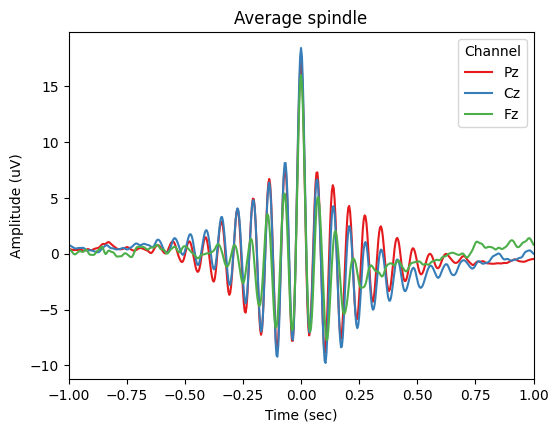

In [31]:
# Plot an average template per channel
spindles_pipe.plot_average(ci=None, palette="Set1")

/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/yasa/detection.py:478: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)


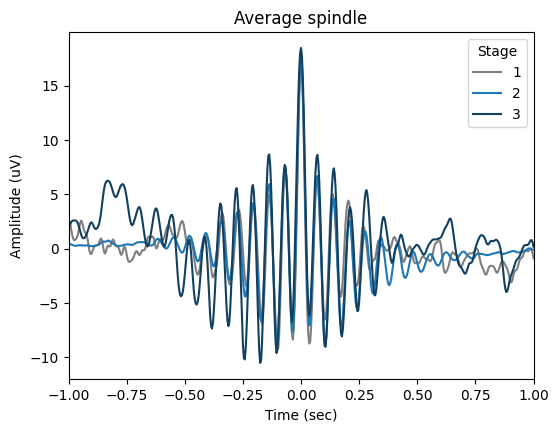

In [32]:
# Plot an average template per stage, using a custom color palette
spindles_pipe.plot_average(hue="Stage", ci=None, palette=['tab:grey', 'tab:blue', '#114061'])

Check agreement between channels

- Using recall score:

In [33]:
spindles_pipe.results.compare_channels(score="recall", max_distance_sec=0.5).round(3)

Channel     Pz     Cz     Fz
Channel                     
Pz       1.000  0.492  0.158
Cz       0.770  1.000  0.258
Fz       0.514  0.536  1.000

- Using F1 score:

In [35]:
spindles_pipe.results.compare_channels(max_distance_sec=0.5).round(3)

Channel     Pz     Cz     Fz
Channel                     
Pz       1.000  0.600  0.242
Cz       0.600  1.000  0.349
Fz       0.242  0.349  1.000

Finding spindles that are present on at least 2 channels

In [36]:
spindles_pipe.detect(picks=['Pz', 'Cz', 'Fz'], remove_outliers=True, multi_only=True)
spindles_pipe.results.summary().round(3)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Start       Peak        End  Duration  Amplitude    RMS  AbsPower  \
0      3993.105   3993.461   3993.656     0.551     30.976  6.989     1.669   
1      4012.367   4013.156   4013.270     0.902     26.006  5.650     1.477   
2      4016.148   4016.824   4017.094     0.945     43.799  8.427     1.969   
3      4060.391   4060.758   4061.031     0.641     34.985  8.376     1.951   
4      4091.992   4092.645   4092.914     0.922     36.814  8.030     1.936   
...         ...        ...        ...       ...        ...    ...       ...   
1262  34464.652  34464.781  34465.164     0.512     33.003  7.678     1.778   
1263  34490.723  34491.043  34491.266     0.543     36.618  7.313     1.794   
1264  34499.891  34500.012  34500.629     0.738     30.080  7.959     1.633   
1265  34504.223  34504.746  34505.391     1.168     35.293  7.642     1.590   
1266  34511.793  34511.988  34512.590     0.797     36.417  8.041     1.823   

      RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
0        0.455     13.955           7.0     0.641      2      Pz           0  
1        0.410     13.731          11.0     0.871      2      Pz           0  
2        0.542     14.575          13.0     0.712      2      Pz           0  
3        0.542     14.456           9.0     0.570      2      Pz           0  
4        0.567     14.267          11.0     0.705      2      Pz           0  
...        ...        ...           ...       ...    ...     ...         ...  
1262     0.298     14.676           7.0     0.250      2      Fz           2  
1263     0.344     14.535           7.0     0.586      2      Fz           2  
1264     0.336     13.677           9.0     0.163      2      Fz           2  
1265     0.329     14.383          15.0     0.447      2      Fz           2  
1266     0.339     13.344          10.0     0.244      2      Fz           2  

[1267 rows x 14 columns]

In [38]:
spindles_pipe.results.summary(grp_chan=True)

Count  Duration  Amplitude       RMS  AbsPower  RelPower  Frequency  \
Channel                                                                        
Cz         520  0.804935  39.344362  8.542995  1.829924  0.381861  14.248696   
Fz         225  0.781198  34.738446  7.594421  1.686585  0.357947  13.705395   
Pz         522  0.922474  36.132445  7.786136  1.793234  0.458417  14.350059   

         Oscillations  Symmetry  
Channel                          
Cz          10.232692  0.483329  
Fz           9.693333  0.501235  
Pz          11.848659  0.490966

Comparing 2 detections

In [37]:
spindles_pipe.results.get_sync_events(center='Peak', time_before=0.8, time_after=0.8)

Time Event  Amplitude  Stage Channel  IdxChannel
0      -0.796875     0  -8.146986      2      Pz           0
1      -0.792969     0  -6.717871      2      Pz           0
2      -0.789062     0  -4.247693      2      Pz           0
3      -0.785156     0  -1.548296      2      Pz           0
4      -0.781250     0   0.349659      2      Pz           0
...          ...   ...        ...    ...     ...         ...
518198  0.781250   224   6.343952      2      Fz           2
518199  0.785156   224   4.551536      2      Fz           2
518200  0.789062   224   1.862920      2      Fz           2
518201  0.792969   224  -1.219273      2      Fz           2
518202  0.796875   224  -3.895462      2      Fz           2

[518203 rows x 6 columns]

In [39]:
spindles_pipe.results.get_coincidence_matrix(scaled=False)

Channel      Pz      Cz     Fz
Channel                       
Pz       123794   86555  26221
Cz        86555  107673  26475
Fz        26221   26475  45222

In [40]:
coincidence = spindles_pipe.results.get_coincidence_matrix()
coincidence

Channel        Pz        Cz        Fz
Channel                              
Pz       1.000000  0.000006  0.000005
Cz       0.000006  1.000000  0.000005
Fz       0.000005  0.000005  1.000000

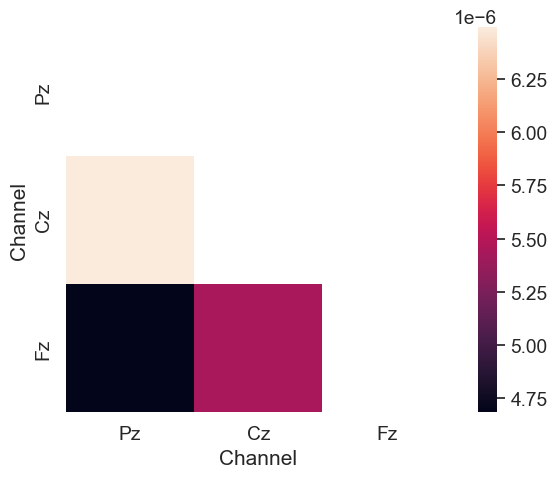

In [41]:
import seaborn as sns
sns.set(style="white", font_scale=1.25)


mask = np.zeros_like(coincidence)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(coincidence, mask=mask, square=True, cmap="rocket")


### 3.2. Slow waves

Hypnogram is SHORTER than data by 5.0 seconds. Padding hypnogram with last value to match data.size.


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


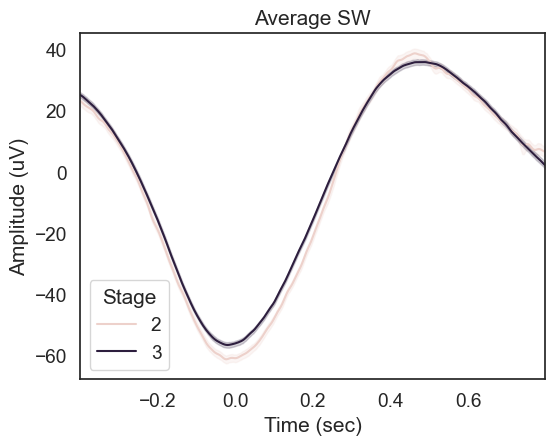

In [42]:
slow_waves_pipe = SlowWavesPipe(prec_pipe=spindles_pipe)
slow_waves_pipe.detect(
    picks=["eeg"],
    reference="average",
    include=(2, 3),
    freq_sw=(0.3, 1.5),
    dur_neg=(0.3, 1.5),
    dur_pos=(0.1, 1),
    amp_neg=(40, 200),
    amp_pos=(10, 150),
    amp_ptp=(75, 350),
    coupling=False,
    coupling_params={"freq_sp": (12, 16), "p": 0.05, "time": 1},
    remove_outliers=False,
    verbose=False,
    save=True,
)

slow_waves_pipe.plot_average(
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
    save=True
)

In [43]:
slow_waves_pipe.results.summary(
    grp_chan=False, grp_stage=True, mask=None, aggfunc="mean", sort=True
)

Count    Density  Duration  ValNegPeak  ValPosPeak         PTP  \
Stage                                                                   
2       2075   8.811040  1.223153  -58.850217   47.844596  106.694813   
3       2114  70.466667  1.137349  -52.812480   43.062356   95.874836   

            Slope  Frequency  
Stage                         
2      402.337233   0.861789  
3      371.695117   0.908944

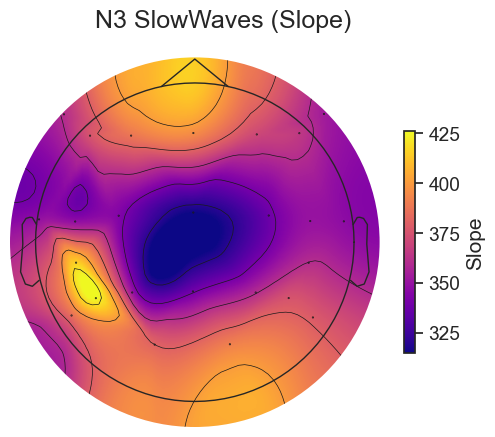

In [44]:
slow_waves_pipe.plot_topomap(
    prop="Slope",  #  Any of the event properties returned by pipe.results.summary().
    stage="N3",  # Stage to plot the topomap for.
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Should contain at least index of the provided "stage".
    sleep_stages={"Wake": 0, "N1": 1, "N2": 2, "N3": 3, "REM": 4},
    axis=None,  # Whether to plot on provided matplotlib axis.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

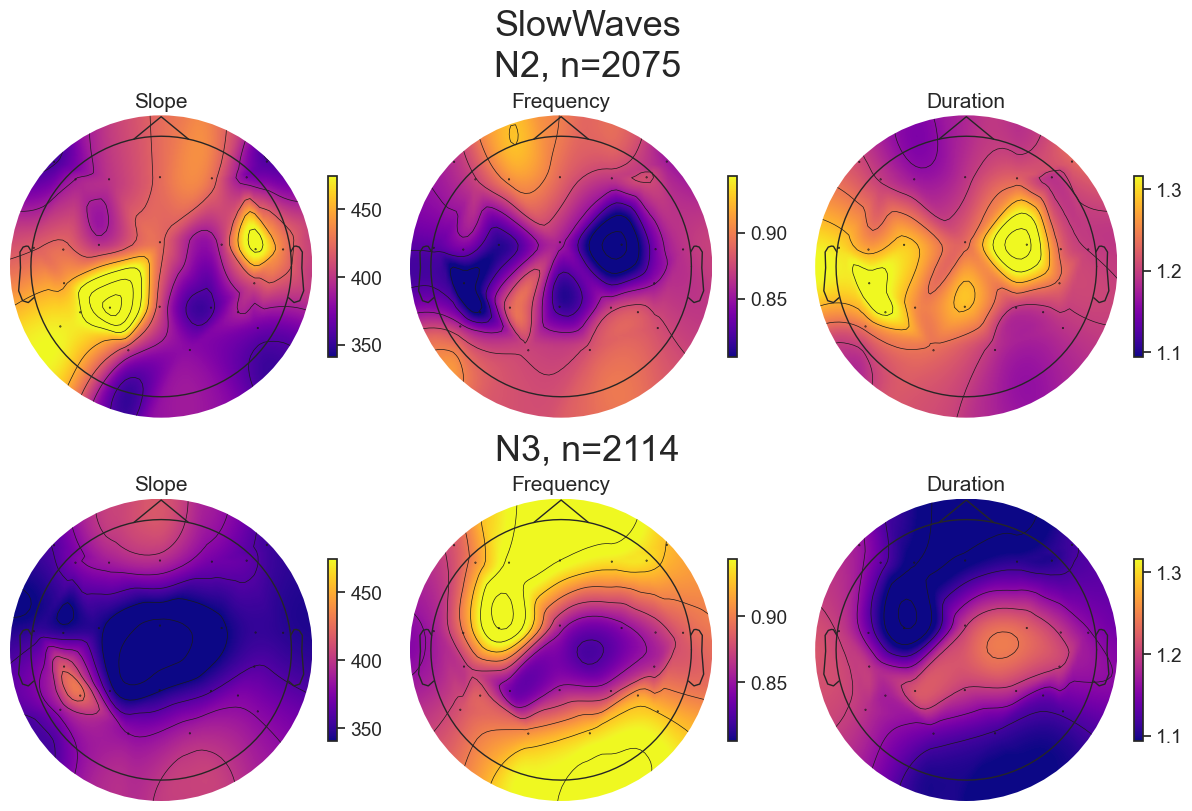

In [45]:
slow_waves_pipe.plot_topomap_collage(
    # Some of the event properties returned by pipe.results.summary().
    props=["Slope", "Frequency", "Duration"],
    aggfunc="mean",  # Aggregation function for channel grouping.
    # Tuple of strs or "all", e.g., ("N1", "REM") or "all" (plots all "sleep_stages").
    stages_to_plot="all",
    # Should contain at least indices of the provided "stages_to_plot".
    sleep_stages={"N2": 2, "N3": 3},
    low_percentile=5,  # Set min color value by percentile of the property data.
    high_percentile=95,  # Set max color value by percentile of the property data.
    fig=None,  # Instance of plt.Figure, a new fig will be created if None.
    save=True,  # Whether to save the plot as a file.
    topomap_args=dict(cmap="plasma"),  # Arguments passed to mne.viz.plot_topomap().
    cbar_args=None,  # Arguments passed to plt.colorbar().
)

In [46]:
slow_waves_pipe.compute_tfr(
    freqs=(0.5, 5), n_freqs=100, time_before=4, time_after=4, n_cycles=2,save=False
)
slow_waves_pipe.tfrs

100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


{'N2': <AverageTFR | time : [-4.000000, 4.000000], freq : [0.500000, 5.000000], nave : 83, channels : 25, ~39.1 MB>,
 'N3': <AverageTFR | time : [-4.000000, 4.000000], freq : [0.500000, 5.000000], nave : 84, channels : 25, ~39.1 MB>}

In [47]:
slow_waves_pipe.tfrs["N2"].to_data_frame()

time  freq            C3            C4            Cz  \
0      -4.000000   0.5  66131.536419  54754.053988  88039.852368   
1      -3.996094   0.5  66797.560755  55206.230037  88735.018971   
2      -3.992188   0.5  67467.163083  55659.371175  89430.964041   
3      -3.988281   0.5  68140.316741  56113.444785  90127.628519   
4      -3.984375   0.5  68816.994275  56568.417985  90824.953047   
...          ...   ...           ...           ...           ...   
204895  3.984375   5.0   1442.931397   8680.089154  75172.699874   
204896  3.988281   5.0   1402.623159   8008.979212  72845.336878   
204897  3.992188   5.0   1356.091590   7347.723445  70147.595433   
204898  3.996094   5.0   1303.784000   6703.040763  67125.125360   
204899  4.000000   5.0   1246.284778   6080.709277  63827.874441   

                 F10            F3            F4            F7            F8  \
0       93040.522932  62707.200076  49949.864462  55293.218012  29125.008323   
1       93857.039511  63245.559040  50379.743328  55741.398416  29356.826692   
2       94676.312952  63785.428640  50810.873508  56190.344476  29589.063783   
3       95498.298292  64326.776275  51243.229993  56640.022624  29821.704314   
4       96322.949933  64869.569095  51676.787585  57090.399101  30054.732989   
...              ...           ...           ...           ...           ...   
204895  13825.986305  11290.579303   6146.690079   7980.962844  10238.248368   
204896  13144.963919  10935.022146   5935.303226   7604.724412   9918.567450   
204897  12433.824342  10531.869716   5698.497042   7211.164877   9546.769969   
204898  11699.467807  10085.395615   5439.298756   6803.685263   9129.107024   
204899  10949.211508   9600.890703   5161.128967   6385.983154   8672.557224   

        ...            P7             P8            P9            Pz  \
0       ...  55449.360299  246613.386236  61172.308972  77129.436467   
1       ...  55938.806156  248613.964486  61687.403248  77517.875908   
2       ...  56430.476758  250620.085251  62203.621512  77904.243997   
3       ...  56924.365101  252631.666257  62720.922200  78288.508429   
4       ...  57420.464132  254648.625352  63239.263280  78670.637621   
...     ...           ...            ...           ...           ...   
204895  ...   4956.426279  744885.483520   8611.846376   5136.154006   
204896  ...   4774.348727  706020.062842   8053.537871   4968.042158   
204897  ...   4574.020068  665293.178822   7499.896675   4777.848114   
204898  ...   4357.585741  623267.332514   6954.268549   4568.086582   
204899  ...   4127.540821  580492.212471   6419.820062   4341.610171   

                  T10            T7             T8            T9  \
0       123420.914714  69723.489149  139861.335855  80839.562760   
1       124555.722155  70310.572466  141142.031536  81499.519557   
2       125695.144120  70899.015402  142427.800484  82160.424940   
3       126839.128318  71488.774505  143718.583189  82822.222874   
4       127987.621888  72079.805883  145014.319574  83484.857043   
...               ...           ...            ...           ...   
204895  290064.362012  13618.126462  277403.857102   9950.484128   
204896  271847.301618  12871.200522  261539.871726   9321.381922   
204897  253495.262576  12094.276494  245255.367607   8689.345165   
204898  235191.339631  11297.440286  228744.818395   8059.969037   
204899  217104.867043  10490.605817  212192.902966   7438.561404   

                  TP7           TP8  
0       214402.127199  44793.050046  
1       216199.304117  45204.751623  
2       218002.477623  45617.947243  
3       219811.584537  46032.609326  
4       221626.561923  46448.710004  
...               ...           ...  
204895  755136.579195  11402.252294  
204896  711632.304675  10776.092820  
204897  666895.465778  10121.144182  
204898  621483.309582   9446.997610  
204899  575925.806542   8762.976663  

[204900 rows x 27 columns]

No baseline correction applied


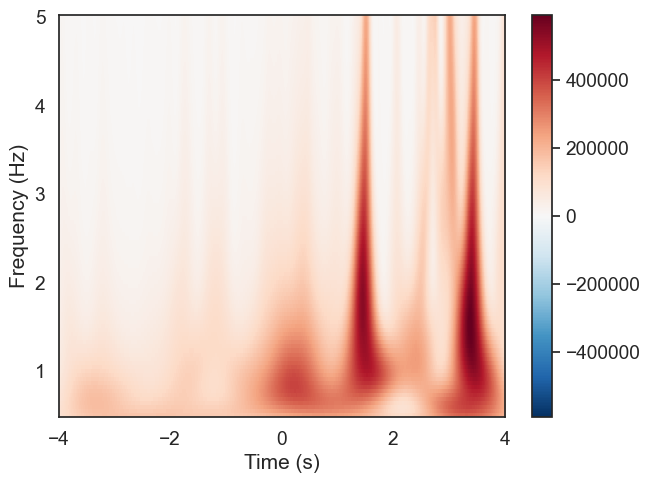

No baseline correction applied


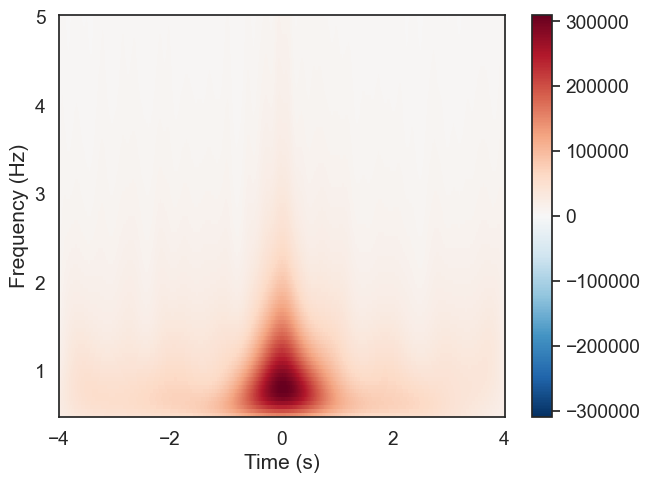

[<Figure size 640x480 with 2 Axes>]

In [48]:
slow_waves_pipe.tfrs["N2"].plot(["Cz"]),
slow_waves_pipe.tfrs["N3"].plot(["Cz"])